In [1]:
import sys
import importlib
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import scipy.ndimage.filters as filters
from distributed import LocalCluster, Client

In [2]:
%matplotlib inline

In [31]:
%matplotlib notebook

In [3]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf
import prepare_sat_data as prep
import random_functions as rf

In [4]:
sensor_data = pd.read_hdf('/home/travis/python_code/letkf_forecasting/data/sensor_data.h5')
sensor_CI = pd.read_hdf('/home/travis/python_code/letkf_forecasting/data/sensor_CI.h5')
sensor_loc = pd.read_hdf('/home/travis/python_code/letkf_forecasting/data/sensor_loc.h5')

In [ ]:
plt.figure()
sensor_CI[sensor_loc[sensor_loc.test==True].id].ix['2014-04-15 12:30' : '2014-04-15 13:30'].plot()

for i in sensor_loc[sensor_loc.test==False].id:
    plt.figure()
    plt.plot(sensor_data[sensor_data.id==i]['clearsky_profile'].ix['2014-04-15'])
    plt.plot(sensor_data[sensor_data.id==i]['ghi'].ix['2014-04-15'])

In [5]:
sensor_loc.sort_values(by='id', inplace=True)

In [6]:
cloudiness_14 = pd.read_hdf('./data/for_15/cloudiness_14.h5')
cloudiness_15 = pd.read_hdf('./data/for_15/cloudiness_15.h5')

corrected_cloudiness = (cloudiness_15 - cloudiness_14).clip(lower=0)
SUNY_coeff = np.array(np.array([2.36, -6.2, 6.22, -2.63, -0.58, 1]))
# cc_crop = corrected_cloudiness[flat_crop_indicies]
# cc_crop.columns = np.arange(flat_crop_indicies.size, dtype='int')

In [7]:
# csi_15 = pd.read_hdf('./data/for_15/csi_15.h5')
U_15 = pd.read_hdf('./data/for_15/U_fine.h5')
V_15 = pd.read_hdf('./data/for_15/V_fine.h5')
U_shape = np.load('./data/for_15/U_fine_shape.npy')
V_shape = np.load('./data/for_15/V_fine_shape.npy')

In [8]:
## filter winds
filter_len = 100*4
U_smooth = U_15.values.reshape(
    [U_15.shape[0], U_shape[0], U_shape[1]])
U_smooth = filters.uniform_filter(
    U_smooth, size=(0, filter_len, filter_len))
this_shape = U_smooth.shape
U_smooth = U_smooth.reshape(this_shape[0], this_shape[1]*this_shape[2])
U_smooth = pd.DataFrame(data=U_smooth, index=U_15.index)

V_smooth = V_15.values.reshape(
    [V_15.shape[0], V_shape[0], V_shape[1]])
V_smooth = filters.uniform_filter(
    V_smooth, size=(0, filter_len, filter_len))
this_shape = V_smooth.shape
V_smooth = V_smooth.reshape(this_shape[0], this_shape[1]*this_shape[2])
V_smooth = pd.DataFrame(data=V_smooth, index=V_15.index)

In [9]:
x_sat = np.load('./data/for_15/x_fine.npy')
y_sat = np.load('./data/for_15/y_fine.npy')
domain_shape = np.load('./data/for_15/fine_shape.npy')

In [10]:
x_range = x_sat.reshape(domain_shape)[0, :]
y_range = y_sat.reshape(domain_shape)[:, 0]

In [11]:
lon_sens = sensor_loc['lon'].values
lat_sens = sensor_loc['lat'].values

In [12]:
x_sens, y_sens = prep.sphere_to_lcc(lat_sens, lon_sens)
x_min = np.floor(x_sens.min())
x_max = np.ceil(x_sens.max())
y_min = np.floor(y_sens.min())
y_max = np.ceil(y_sens.max())
west_east_min = np.argmin(abs(x_min - x_range))
west_east_max = np.argmin(abs(x_max - x_range))
south_north_min = np.argmin(abs(y_min - y_range))
south_north_max = np.argmin(abs(y_max - y_range))

# Crop for mean field domain

In [ ]:
U_max = U_15.values.max() # know U is positive
V_max = abs(V_15.values.min()) # know V is negative

left = int(2*U_max*60*30/250) + 40
right = 40

up = int(2*V_max*60*30/250) + 40
down = 40

west_east_range = np.arange(west_east_min - left, west_east_max + right + 1, dtype='int')
west_east_range_stag = np.arange(west_east_min - left, west_east_max + right + 1 + 1, dtype='int')
south_north_range = np.arange(south_north_min - down, south_north_max + up + 1, dtype='int')
south_north_range_stag = np.arange(south_north_min - down, south_north_max + up + 1 + 1, dtype='int')
crop_shape = (south_north_range.size, west_east_range.size)
U_crop_shape = (south_north_range.size, west_east_range_stag.size)
V_crop_shape = (south_north_range_stag.size, west_east_range.size)
print('X length: ' + 
      str(west_east_range.size))
print('Y length: ' + 
      str(south_north_range.size))

In [ ]:
west_east_crop, south_north_crop = np.meshgrid(west_east_range, south_north_range)
crop_indicies_2d = np.array([south_north_crop.ravel(),
                             west_east_crop.ravel()])
flat_crop_indicies = np.ravel_multi_index(crop_indicies_2d,
                                          domain_shape)

In [ ]:
west_east_crop_U, south_north_crop_U = np.meshgrid(west_east_range_stag, south_north_range)
crop_indicies_2d_U = np.array([south_north_crop_U.ravel(),
                               west_east_crop_U.ravel()])
flat_crop_indicies_U = np.ravel_multi_index(crop_indicies_2d_U,
                                            U_shape)

In [ ]:
west_east_crop_V, south_north_crop_V = np.meshgrid(west_east_range, south_north_range_stag)
crop_indicies_2d_V = np.array([south_north_crop_V.ravel(),
                               west_east_crop_V.ravel()])
flat_crop_indicies_V = np.ravel_multi_index(crop_indicies_2d_V,
                                            V_shape)

In [ ]:
l_x = x_sat[flat_crop_indicies]
l_y = y_sat[flat_crop_indicies]

In [ ]:
l_x_crop_range = l_x.reshape(crop_shape)[0, :]
l_y_crop_range = l_y.reshape(crop_shape)[:, 0]

In [ ]:
l_cci = corrected_cloudiness[flat_crop_indicies]
l_cci.columns = np.arange(flat_crop_indicies.size, dtype='int')
l_csi = pd.DataFrame(data=np.polyval(SUNY_coeff, l_cci),
                        index=l_cci.index)

In [ ]:
l_U = U_smooth[flat_crop_indicies_U]
l_U.columns = np.arange(flat_crop_indicies_U.size, dtype='int')
l_V = V_smooth[flat_crop_indicies_V]
l_V.columns = np.arange(flat_crop_indicies_V.size, dtype='int')

In [ ]:
l_U_const = pd.DataFrame(data=np.ones_like(l_U),
                       index=l_U.index)*22.9
l_V_const = pd.DataFrame(data=np.ones_like(l_V),
                       index=l_V.index)*-2

# crop for assimilation domain

In [13]:
x_sat = np.load('./data/for_15/x_fine.npy')
y_sat = np.load('./data/for_15/y_fine.npy')
domain_shape = np.load('./data/for_15/fine_shape.npy')

In [14]:
x_range = x_sat.reshape(domain_shape)[0, :]
y_range = y_sat.reshape(domain_shape)[:, 0]

In [15]:
lon_sens = sensor_loc['lon'].values
lat_sens = sensor_loc['lat'].values

In [16]:
x_sens, y_sens = prep.sphere_to_lcc(lat_sens, lon_sens)
x_min = np.floor(x_sens.min())
x_max = np.ceil(x_sens.max())
y_min = np.floor(y_sens.min())
y_max = np.ceil(y_sens.max())
west_east_min = np.argmin(abs(x_min - x_range))
west_east_max = np.argmin(abs(x_max - x_range))
south_north_min = np.argmin(abs(y_min - y_range))
south_north_max = np.argmin(abs(y_max - y_range))

In [17]:
U_max = U_15.values.max() # know U is positive
V_max = abs(V_15.values.min()) # know V is negative

left = int(U_max*60*30/250) + 40
right = 40

up = int(V_max*60*30/250) + 40
down = 40

west_east_range = np.arange(west_east_min - left, west_east_max + right + 1, dtype='int')
west_east_range_stag = np.arange(west_east_min - left, west_east_max + right + 1 + 1, dtype='int')
south_north_range = np.arange(south_north_min - down, south_north_max + up + 1, dtype='int')
south_north_range_stag = np.arange(south_north_min - down, south_north_max + up + 1 + 1, dtype='int')
crop_shape = (south_north_range.size, west_east_range.size)
U_crop_shape = (south_north_range.size, west_east_range_stag.size)
V_crop_shape = (south_north_range_stag.size, west_east_range.size)
print('X length: ' + 
      str(west_east_range.size))
print('Y length: ' + 
      str(south_north_range.size))

X length: 478
Y length: 393


In [18]:
west_east_crop, south_north_crop = np.meshgrid(west_east_range, south_north_range)
crop_indicies_2d = np.array([south_north_crop.ravel(),
                             west_east_crop.ravel()])
flat_crop_indicies = np.ravel_multi_index(crop_indicies_2d,
                                          domain_shape)

In [19]:
west_east_crop_U, south_north_crop_U = np.meshgrid(west_east_range_stag, south_north_range)
crop_indicies_2d_U = np.array([south_north_crop_U.ravel(),
                               west_east_crop_U.ravel()])
flat_crop_indicies_U = np.ravel_multi_index(crop_indicies_2d_U,
                                            U_shape)

In [20]:
west_east_crop_V, south_north_crop_V = np.meshgrid(west_east_range, south_north_range_stag)
crop_indicies_2d_V = np.array([south_north_crop_V.ravel(),
                               west_east_crop_V.ravel()])
flat_crop_indicies_V = np.ravel_multi_index(crop_indicies_2d_V,
                                            V_shape)

In [21]:
x_crop = x_sat[flat_crop_indicies]
y_crop = y_sat[flat_crop_indicies]

In [22]:
x_crop_range = x_crop.reshape(crop_shape)[0, :]
y_crop_range = y_crop.reshape(crop_shape)[:, 0]

In [23]:
west_east_min = np.argmin(abs(x_min - x_crop_range))
west_east_max = np.argmin(abs(x_max - x_crop_range))
south_north_min = np.argmin(abs(y_min - y_crop_range))
south_north_max = np.argmin(abs(y_max - y_crop_range))
we_error_range = np.arange(west_east_min - 8, west_east_max + 9, dtype='int')
sn_error_range = np.arange(south_north_min - 8, south_north_max + 9, dtype='int')
error_domain_shape = (sn_error_range.size, we_error_range.size)
print('X length: ' + 
      str(we_error_range.size))
print('Y length: ' + 
      str(sn_error_range.size))

X length: 177
Y length: 241


In [24]:
west_east_error_crop, south_north_error_crop = np.meshgrid(
    we_error_range, sn_error_range)
crop_indicies_2d_error = np.array([south_north_error_crop.ravel(),
                             west_east_error_crop.ravel()])
flat_error_domain = np.ravel_multi_index(crop_indicies_2d_error,
                                         crop_shape)

In [25]:
cci_crop = corrected_cloudiness[flat_crop_indicies]
cci_crop.columns = np.arange(flat_crop_indicies.size, dtype='int')
csi_crop = pd.DataFrame(data=np.polyval(SUNY_coeff, cci_crop),
                        index=cci_crop.index)

In [26]:
U_crop = U_smooth[flat_crop_indicies_U]
U_crop.columns = np.arange(flat_crop_indicies_U.size, dtype='int')
V_crop = V_smooth[flat_crop_indicies_V]
V_crop.columns = np.arange(flat_crop_indicies_V.size, dtype='int')

In [27]:
U_const = pd.DataFrame(data=np.ones_like(U_crop),
                       index=U_crop.index)*22.9
V_const = pd.DataFrame(data=np.ones_like(V_crop),
                       index=V_crop.index)*-2

In [28]:
n_workers = 20
cluster = LocalCluster(n_workers=n_workers, scheduler_port=7001, diagnostics_port=7002)
client = Client(cluster)

In [ ]:
importlib.reload(rf)
Lx = 10 # 1
Ly = 10 # 1
tol = 0.001
e, v = rf.eig_2d_covariance(
    x=x_crop_range, y=y_crop_range,
    Lx=Lx, Ly=Ly, tol=tol)

In [ ]:
approx_var = (v*e[None, :]*v).sum(-1).mean()

In [ ]:
np.save('./data/rf_eigenvalues', e)
np.save('./data/rf_eigenvectors', v)
np.save('./data/rf_approx_var', approx_var)

In [29]:
e = np.load('./data/rf_eigenvalues.npy')
v = np.load('./data/rf_eigenvectors.npy')
approx_var = np.load('./data/rf_approx_var.npy').item()

In [ ]:
### WORKS WELL
### Without wind assimilation


# # Assimilation only of sat to sat
# importlib.reload(lf)
# dx = 250 #in km
# dy = 250 #in km
# C_max = 0.7
# assimilation_grid_size = 1 #was 5
# localization_letkf = 5
# sat_inflation = 1.5

# goes15_azimuth = 220.5
# goes15_elevation = 44.1

# sat_sig = 0.01 #0.01 <- sd<rmse
# ens_size = 40
# wind_sigma = (2, 2)
# wind_size = 2
# CI_sigma = .2

# # works: const - 3 (2, 2) .2, 0.01, loc: 1
# start_time = '2014-04-15 12:15:00' #11:00:00 is not a bad start
# end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

# U_corrected = U_const - 3
# V_corrected = V_const

# returned = lf.main_only_sat(
#     sat=csi_crop, x=x_crop, y=y_crop, domain_shape=crop_shape,                                                                                                                                                    
#     U=U_corrected, U_shape=U_crop_shape, V=V_corrected, V_shape=V_crop_shape,                                                                                                                                                            
#     start_time=start_time, end_time=end_time, dx=dx, dy=dy, C_max=C_max,                                                                                                                                               
#     assimilation_grid_size=assimilation_grid_size,                                                                                                                                                            
#     localization_letkf=localization_letkf, sat_inflation=sat_inflation,                                                                                                                                                
#     sat_sig=sat_sig, ens_size=ens_size,                                                                                                                                                                 
#     wind_sigma=wind_sigma, wind_size=wind_size,
#     CI_sigma=CI_sigma,
#     client=client, flat_error_domain=flat_error_domain,
#     wind_inflation=None,
#     wind_sat_sig=None)
# analysis, analysis_error, analysis_sd = returned[0:3]
# background, background_error, background_sd = returned[3:6]
# advected, used_sat, error_stats = returned[6:9]

In [30]:
%%timeit -n1 -r1
## Assimilation only of sat to sat

## Try to use a seperate sigma for wind assimilation
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 0.7
assimilation_grid_size = 1 #was 5
localization_letkf = 5
sat_inflation = 1.5
wind_inflation = 4
wind_sat_sig = 2.5

goes15_azimuth = 220.5
goes15_elevation = 44.1

sat_sig = 0.05 #0.01 <- sd<rmse
ens_size = 40
wind_sigma = (1.8, 1.8) #(1.5, 1.5)
wind_size = 2
CI_sigma = .2

pert_sigma = 0.09/3 # 0.10/3
pert_mean = 0 # -0.02/3 # 0, 0.05, 0.01
edge_weight = 1

# works: const - 3 (2, 2) .2, 0.01, loc: 1
start_time = '2014-04-15 12:30:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

U_corrected = U_const # - 3
V_corrected = V_const

returned = lf.main_only_sat(
    sat=csi_crop, x=x_crop, y=y_crop, domain_shape=crop_shape,                                                                                                                                                    
    U=U_corrected, U_shape=U_crop_shape, V=V_corrected, V_shape=V_crop_shape,                                                                                                                                                            
    start_time=start_time, end_time=end_time, dx=dx, dy=dy, C_max=C_max,                                                                                                                                               
    assimilation_grid_size=assimilation_grid_size,                                                                                                                                                            
    localization_letkf=localization_letkf, sat_inflation=sat_inflation,                                                                                                                                                
    sat_sig=sat_sig, ens_size=ens_size,                                                                                                                                                                 
    wind_sigma=wind_sigma, wind_size=wind_size,
    CI_sigma=CI_sigma,
    client=client, flat_error_domain=flat_error_domain,
    wind_inflation=wind_inflation,
    wind_sat_sig=wind_sat_sig,
    pert_sigma=pert_sigma, pert_mean=pert_mean,
    rf_eig=e, rf_vectors=v, rf_approx_var=approx_var,
    edge_weight=edge_weight)
analysis, analysis_error, analysis_sd = returned[0:3]
background, background_error, background_sd = returned[3:6]
advected, advected_error = returned[6:8]
used_sat, error_stats = returned[8:10]
background_ni, background_error_ni, background_sd_ni = returned[10:13]                                                             
advected_ni, advected_error_ni = returned[13:15]                                                                                   
used_sat_ni, error_stats_ni = returned[15:17]

time_index: 0
advection_number: 0
advection_number: 1
advection_number: 2
advection_number_ni: 0
advection_number_ni: 1
advection_number_ni: 2
time_index: 1
advection_number: 0
advection_number: 1
advection_number: 2
advection_number_ni: 0
advection_number_ni: 1
advection_number_ni: 2
time_index: 2
advection_number: 0
advection_number: 1
advection_number: 2
advection_number_ni: 0
advection_number_ni: 1
advection_number_ni: 2
time_index: 3
advection_number: 0
advection_number: 1
advection_number: 2
advection_number_ni: 0
advection_number_ni: 1
advection_number_ni: 2
advection_number_ni: 3
advection_number_ni: 4
advection_number_ni: 5


In [ ]:
# directory = 'only_sat/works_ok'
directory = 'None'
analysis.to_hdf('./results/{}/analysis.h5'.format(directory), 'analysis')
analysis_sd.to_hdf('./results/{}/analysis_sd.h5'.format(directory), 'analysis_sd')
analysis_error.to_hdf('./results/{}/analysis_error.h5'.format(directory), 'analysis_error')
background.to_hdf('./results/{}/background.h5'.format(directory), 'background')
background_sd.to_hdf('./results/{}/background_sd.h5'.format(directory), 'background_sd')
background_error.to_hdf('./results/{}/background_error.h5'.format(directory), 'background')
advected.to_hdf('./results/{}/advected.h5'.format(directory), 'advected')
used_sat.to_hdf('./results/{}/used_sat.h5'.format(directory), 'used_sat')
error_stats.to_hdf('./results/{}/error_stats.h5'.format(directory), 'error_stats')

In [ ]:
directory = 'only_sat/works_ok'
# directory = 'None'
analysis = pd.read_hdf('./results/{}/analysis.h5'.format(directory))
analysis_sd = pd.read_hdf('./results/{}/analysis_sd.h5'.format(directory), 'analysis_sd')
analysis_error = pd.read_hdf('./results/{}/analysis_error.h5'.format(directory), 'analysis_error')
background = pd.read_hdf('./results/{}/background.h5'.format(directory), 'background')
background_sd = pd.read_hdf('./results/{}/background_sd.h5'.format(directory), 'background_sd')
background_error = pd.read_hdf('./results/{}/background_error.h5'.format(directory), 'background')
advected = pd.read_hdf('./results/{}/advected.h5'.format(directory), 'advected')
used_sat = pd.read_hdf('./results/{}/used_sat.h5'.format(directory), 'used_sat')
error_stats = pd.read_hdf('./results/{}/error_stats.h5'.format(directory), 'error_stats')

<IPython.core.display.Javascript object>


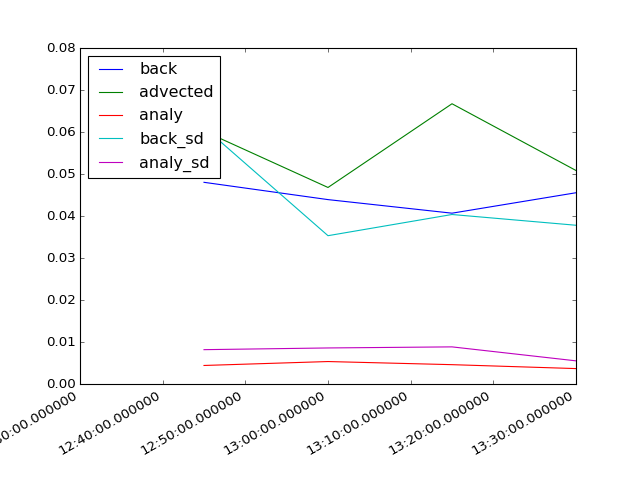

In [33]:
to_plot = ['back', 'advected', 'analy', 'back_sd', 'analy_sd']
# to_plot = ['sat', 'oi']
error_stats[to_plot].plot()
plt.ylim([0, 0.08])
plt.legend(loc='upper left')

(0, 0.08)

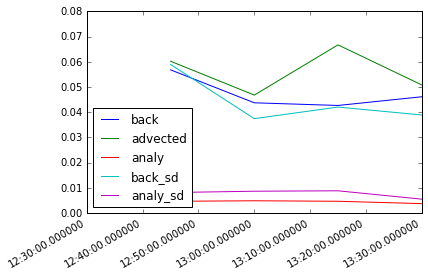

In [73]:
to_plot = ['back', 'advected', 'analy', 'back_sd', 'analy_sd']
# to_plot = ['sat', 'oi']
error_stats[to_plot].plot()
plt.ylim([0, 0.08])

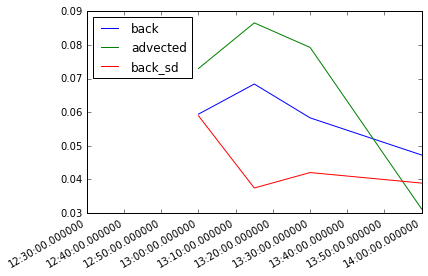

In [78]:
to_plot = ['back', 'advected', 'back_sd']
error_stats_ni[to_plot].plot()
# plt.ylim([0, 0.08])

(0.029999999999999999, 0.16)

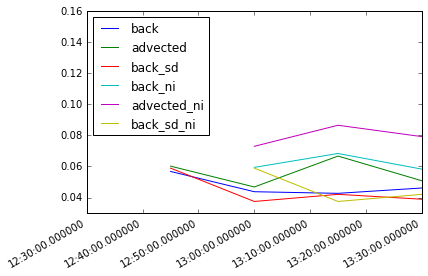

In [95]:
to_plot = ['back', 'advected', 'back_sd']
# to_plot = ['sat', 'oi']
ax = error_stats[to_plot].plot()
error_stats_ni[to_plot].iloc[slice(None, -1)].plot(ax=ax)
plt.legend(
    ['back', 'advected', 'back_sd', 'back_ni', 'advected_ni', 'back_sd_ni'],
    loc='upper left')
plt.ylim([None, 0.16])

(0, 0.08)

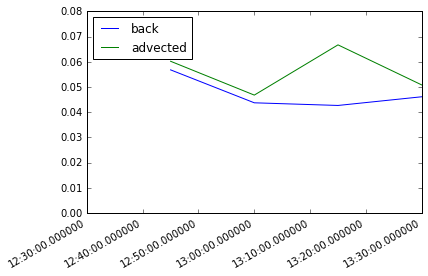

In [74]:
to_plot = ['back', 'advected']
# to_plot = ['sat', 'oi']
error_stats[to_plot].plot()
plt.ylim([0, 0.08])

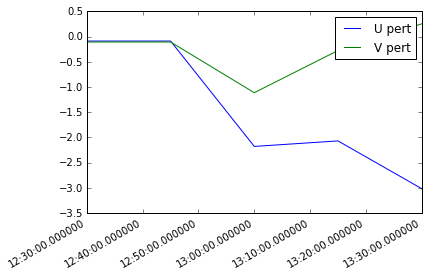

In [45]:
ax = background[0].plot()
background[1].plot(ax=ax)
plt.legend(['U pert', 'V pert'])

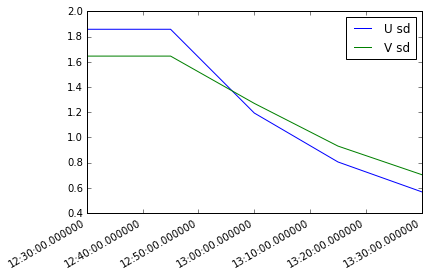

In [46]:
ax = background_sd[0].plot()
background_sd[1].plot(ax=ax)
plt.legend(['U sd', 'V sd'])

<IPython.core.display.Javascript object>


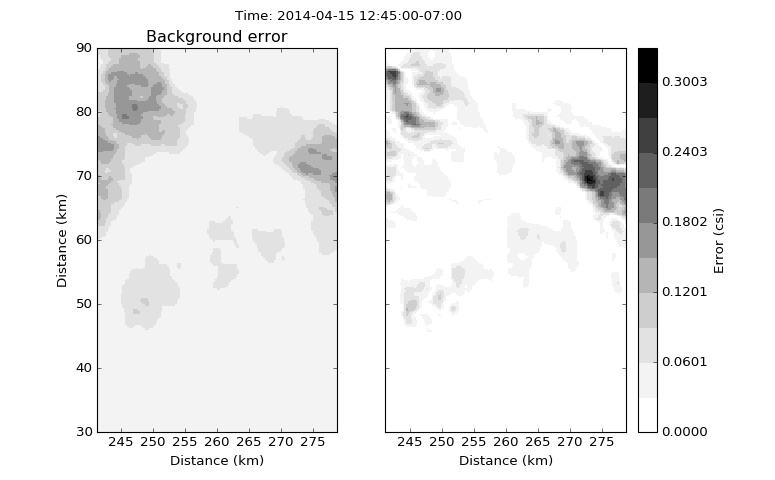

<IPython.core.display.Javascript object>


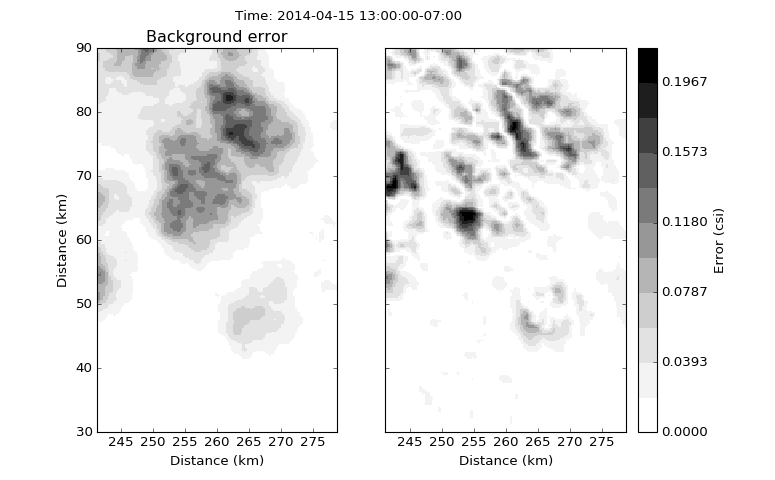

<IPython.core.display.Javascript object>


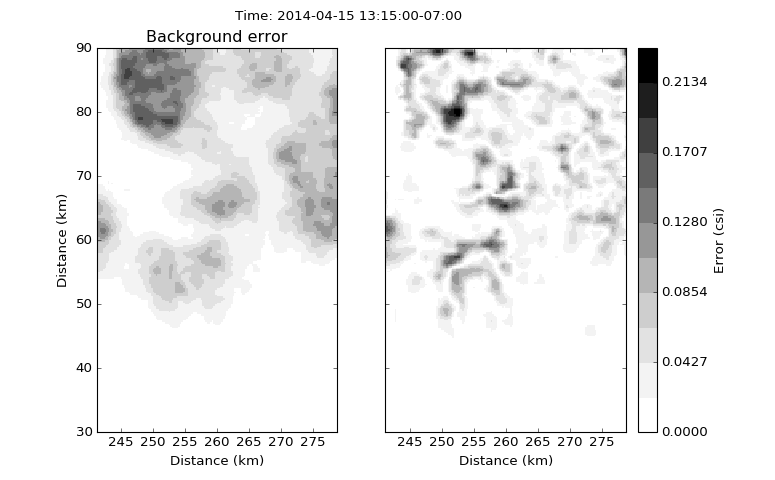

<IPython.core.display.Javascript object>


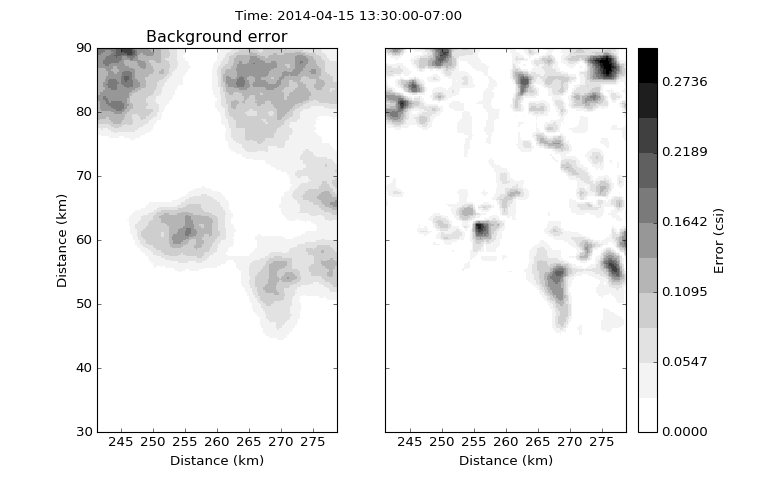

In [34]:
shape = crop_shape

sn_crop = slice(None, None)
we_crop = slice(None, None)
for t in np.arange(analysis.index.size - 1) + 1:
    this_time = analysis.index[t]
    
    vmin = 0
    vmax = 1
    nc = 12
    bounds = np.linspace(vmin, vmax, nc)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fraction = 0.10
    suptitle_x = .5*(1 - fraction)
    
#     ## Analysis and Background
#     this_x = x_crop.reshape(shape)[sn_crop, we_crop]
#     this_y = y_crop.reshape(shape)[sn_crop, we_crop]
#     nrows, ncols = 1, 2
#     dy, dx = this_x.shape
#     figsize = plt.figaspect(float(dy * nrows) / ((1 + fraction)*float(dx * ncols)))
#     fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
#     plt.suptitle('Time: {time}'.format(time=str(this_time)), x=suptitle_x)
#     im = ax1.pcolormesh(
#         this_x,
#         this_y,
#         background.loc[this_time].values[2:].reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', norm=norm)
#     ax1.set_title('Background')
#     im = ax2.pcolormesh(
#         this_x,
#         this_y,
#         analysis.loc[this_time].values[2:].reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', norm=norm)
#     ax2.set_title('Analysis')
#     cb = plt.colorbar(im, ax=(ax1, ax2), pad=0.02, fraction=fraction)
#     cb.set_label('Clear Sky Index')
#     ax1.set_aspect('equal', 'datalim')
#     ax2.set_aspect('equal', 'datalim')
#     ax1.set_xlabel('Distance (km)')
#     ax1.set_ylabel('Distance (km)')
#     ax2.set_xlabel('Distance (km)')
    
    
#     ## Background and Advected
#     this_x = x_crop.reshape(shape)[sn_crop, we_crop]
#     this_y = y_crop.reshape(shape)[sn_crop, we_crop]
#     nrows, ncols = 1, 2
#     dy, dx = this_x.shape
#     figsize = plt.figaspect(float(dy * nrows) / ((1 + fraction)*float(dx * ncols)))
#     fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
#     plt.suptitle('Time: {time}'.format(time=str(this_time)), x=suptitle_x)
#     im = ax1.pcolormesh(
#         this_x,
#         this_y,
#         background.loc[this_time].values[2:].reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', norm=norm)
#     ax1.set_title('Background')
#     im = ax2.pcolormesh(
#         this_x,
#         this_y,
#         advected.loc[this_time].values.reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', norm=norm)
#     ax2.set_title('Advected')
#     cb = plt.colorbar(im, ax=(ax1, ax2), pad=0.02, fraction=fraction)
#     cb.set_label('Clear Sky Index')
#     ax1.set_aspect('equal', 'datalim')
#     ax2.set_aspect('equal', 'datalim')
#     ax1.set_xlabel('Distance (km)')
#     ax1.set_ylabel('Distance (km)')
#     ax2.set_xlabel('Distance (km)')
    
    ## Background sd and error
    this_vmax = np.max([background_sd.loc[this_time]
                       .values[flat_error_domain + wind_size].max(),
                       abs(background_error.loc[this_time])
                       .values[flat_error_domain + wind_size].max()])
    these_bounds = np.linspace(vmin, this_vmax, nc)
    this_norm = colors.BoundaryNorm(boundaries=these_bounds, ncolors=256)
    this_x = x_crop[flat_error_domain].reshape(error_domain_shape)
    this_y = y_crop[flat_error_domain].reshape(error_domain_shape)
    nrows, ncols = 1, 2
    dy, dx = this_x.shape
    figsize = plt.figaspect(float(dy * nrows) / ((1 + fraction)*float(dx * ncols)))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
    plt.suptitle('Time: {time}'.format(time=str(this_time)), x=suptitle_x)
    im = ax1.pcolormesh(
        this_x,
        this_y,
        background_sd.loc[this_time]
        .values[flat_error_domain + wind_size]
        .reshape(error_domain_shape),
        cmap='Greys', norm=this_norm)
    ax1.set_title('Background sd')
    im = ax2.pcolormesh(
        this_x,
        this_y,
        abs(background_error.loc[this_time])
        .values[flat_error_domain + wind_size]
        .reshape(error_domain_shape),
        cmap='Greys', norm=this_norm)
    ax1.set_title('Background error')
    cb = plt.colorbar(im, ax=(ax1, ax2), pad=0.02, fraction=fraction)
    cb.set_label('Error (csi)')
    ax1.set_aspect('equal', 'datalim')
    ax2.set_aspect('equal', 'datalim')
    ax1.set_xlabel('Distance (km)')
    ax1.set_ylabel('Distance (km)')
    ax2.set_xlabel('Distance (km)')

#     ## Background error and advected error
#     this_vmax = np.max([background_sd.loc[this_time]
#                        .values[flat_error_domain + wind_size].max(),
#                        abs(background_error.loc[this_time])
#                        .values[flat_error_domain + wind_size].max()])
#     these_bounds = np.linspace(vmin, this_vmax, nc)
#     this_norm = colors.BoundaryNorm(boundaries=these_bounds, ncolors=256)
#     this_x = x_crop[flat_error_domain].reshape(error_domain_shape)
#     this_y = y_crop[flat_error_domain].reshape(error_domain_shape)
#     nrows, ncols = 1, 2
#     dy, dx = this_x.shape
#     figsize = plt.figaspect(float(dy * nrows) / ((1 + fraction)*float(dx * ncols)))
#     fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
#     plt.suptitle('Time: {time}'.format(time=str(this_time)), x=suptitle_x)
#     im = ax1.pcolormesh(
#         this_x,
#         this_y,
#         abs(background_error.loc[this_time])
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap='Greys', norm=this_norm)
#     ax1.set_title('Background error')
#     im = ax2.pcolormesh(
#         this_x,
#         this_y,
#         abs(advected_error.loc[this_time])
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap='Greys', norm=this_norm)
#     ax2.set_title('advected error')
#     cb = plt.colorbar(im, ax=(ax1, ax2), pad=0.02, fraction=fraction)
#     cb.set_label('Error (csi)')
#     ax1.set_aspect('equal', 'datalim')
#     ax2.set_aspect('equal', 'datalim')
#     ax1.set_xlabel('Distance (km)')
#     ax1.set_ylabel('Distance (km)')
#     ax2.set_xlabel('Distance (km)')
    

#     ## advected and used sat
#     this_x = x_crop.reshape(shape)[sn_crop, we_crop]
#     this_y = y_crop.reshape(shape)[sn_crop, we_crop]
#     nrows, ncols = 1, 2
#     dy, dx = this_x.shape
#     figsize = plt.figaspect(float(dy * nrows) / ((1 + fraction)*float(dx * ncols)))
#     fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
#     plt.suptitle('Time: {time}'.format(time=str(this_time)), x=suptitle_x)
#     im = ax1.pcolormesh(
#         this_x,
#         this_y,
#         advected.loc[this_time].values.reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', norm=norm)
#     ax1.set_title('Advected')
#     im = ax2.pcolormesh(
#         this_x,
#         this_y,
#         used_sat.loc[this_time].values.reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', norm=norm)
#     ax2.set_title('New Sat Image')
#     cb = plt.colorbar(im, ax=(ax1, ax2), pad=0.02, fraction=fraction)
#     cb.set_label('Clear Sky Index')
#     ax1.set_aspect('equal', 'datalim')
#     ax2.set_aspect('equal', 'datalim')
#     ax1.set_xlabel('Distance (km)')
#     ax1.set_ylabel('Distance (km)')
#     ax2.set_xlabel('Distance (km)')
    
#     ## Analysis sd and error
#     this_vmax = np.max([analysis_sd.loc[this_time]
#                        .values[flat_error_domain + wind_size].max(),
#                        abs(analysis_error.loc[this_time])
#                        .values[flat_error_domain + wind_size].max()])
#     these_bounds = np.linspace(vmin, this_vmax, nc)
#     this_norm = colors.BoundaryNorm(boundaries=these_bounds, ncolors=256)
#     this_x = x_crop[flat_error_domain].reshape(error_domain_shape)
#     this_y = y_crop[flat_error_domain].reshape(error_domain_shape)
#     nrows, ncols = 1, 2
#     dy, dx = this_x.shape
#     figsize = plt.figaspect(float(dy * nrows) / ((1 + fraction)*float(dx * ncols)))
#     fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
#     plt.suptitle('Time: {time}'.format(time=str(this_time)), x=suptitle_x)
#     im = ax1.pcolormesh(
#         this_x,
#         this_y,
#         analysis_sd.loc[this_time]
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap='Greys', norm=this_norm)
#     ax1.set_title('Analysis sd')
#     im = ax2.pcolormesh(
#         this_x,
#         this_y,
#         abs(analysis_error.loc[this_time])
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap='Greys', norm=this_norm)
#     ax2.set_title('Analysis Absolute Error')
#     cb = plt.colorbar(im, ax=(ax1, ax2), pad=0.02, fraction=fraction)
#     cb.set_label('Error (csi)')
#     ax1.set_aspect('equal', 'datalim')
#     ax2.set_aspect('equal', 'datalim')
#     ax1.set_xlabel('Distance (km)')
#     ax1.set_ylabel('Distance (km)')
#     ax2.set_xlabel('Distance (km)')

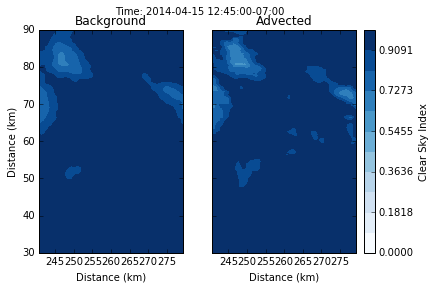

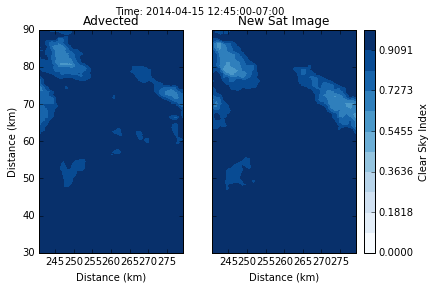

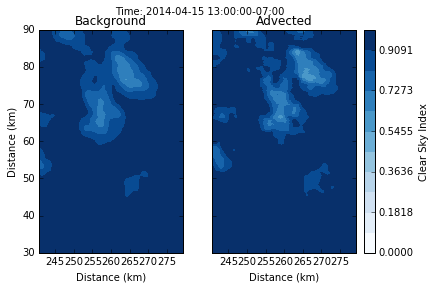

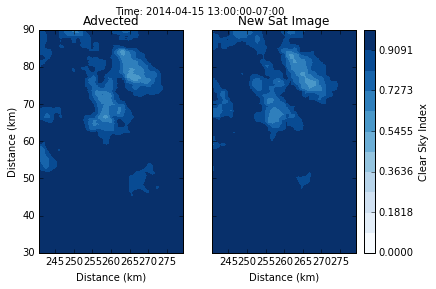

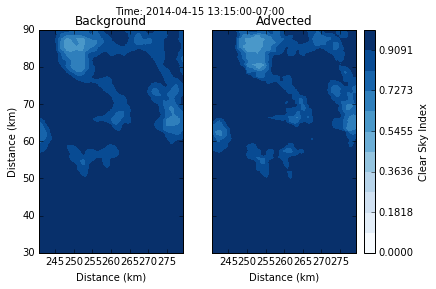

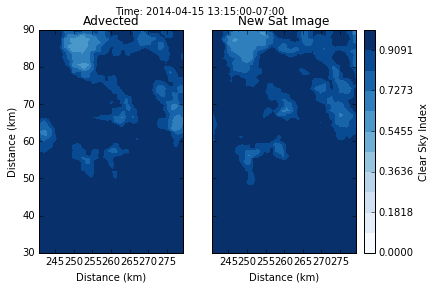

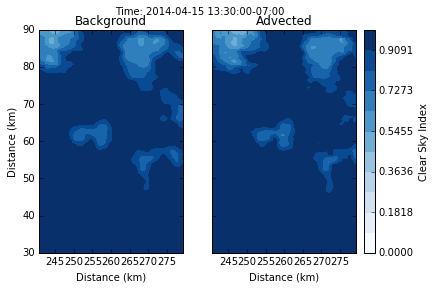

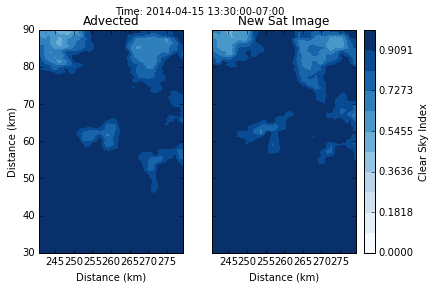

In [41]:
## Only error domain
shape = crop_shape

sn_crop = slice(None, None)
we_crop = slice(None, None)
for t in np.arange(analysis.index.size - 1) + 1:
    this_time = analysis.index[t]
    
    vmin = 0
    vmax = 1
    nc = 12
    bounds = np.linspace(vmin, vmax, nc)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fraction = 0.10
    suptitle_x = .5*(1 - fraction)
    
#     ## Analysis and Background
#     this_x = x_crop[flat_error_domain].reshape(error_domain_shape)
#     this_y = y_crop[flat_error_domain].reshape(error_domain_shape)
#     nrows, ncols = 1, 2
#     dy, dx = this_x.shape
#     figsize = plt.figaspect(float(dy * nrows) / ((1 + fraction)*float(dx * ncols)))
#     fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
#     plt.suptitle('Time: {time}'.format(time=str(this_time)), x=.47)
#     im = ax1.pcolormesh(
#         this_x,
#         this_y,
#         background.loc[this_time]
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap='Blues', norm=norm)
#     ax1.set_title('Background')
#     im = ax2.pcolormesh(
#         this_x,
#         this_y,
#         analysis.loc[this_time]
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap='Blues', norm=norm)
#     ax2.set_title('Analysis')
#     cb = plt.colorbar(im, ax=(ax1, ax2), pad=0.02, fraction=fraction)
#     cb.set_label('Clear Sky Index')
#     ax1.set_aspect('equal', 'datalim')
#     ax2.set_aspect('equal', 'datalim')
#     ax1.set_xlabel('Distance (km)')
#     ax1.set_ylabel('Distance (km)')
#     ax2.set_xlabel('Distance (km)')

    ## Background and advected
    this_x = x_crop[flat_error_domain].reshape(error_domain_shape)
    this_y = y_crop[flat_error_domain].reshape(error_domain_shape)
    nrows, ncols = 1, 2
    dy, dx = this_x.shape
    figsize = plt.figaspect(float(dy * nrows) / ((1 + fraction)*float(dx * ncols)))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
    plt.suptitle('Time: {time}'.format(time=str(this_time)), x=.47)
    im = ax1.pcolormesh(
        this_x,
        this_y,
        background.loc[this_time]
        .values[flat_error_domain + wind_size]
        .reshape(error_domain_shape),
        cmap='Blues', norm=norm)
    ax1.set_title('Background')
    im = ax2.pcolormesh(
        this_x,
        this_y,
        advected.loc[this_time]
        .values[flat_error_domain]
        .reshape(error_domain_shape),
        cmap='Blues', norm=norm)
    ax2.set_title('Advected')
    cb = plt.colorbar(im, ax=(ax1, ax2), pad=0.02, fraction=fraction)
    cb.set_label('Clear Sky Index')
    ax1.set_aspect('equal', 'datalim')
    ax2.set_aspect('equal', 'datalim')
    ax1.set_xlabel('Distance (km)')
    ax1.set_ylabel('Distance (km)')
    ax2.set_xlabel('Distance (km)')
    
#     ## Background sd and error
#     this_vmax = np.max([background_sd.loc[this_time]
#                        .values[flat_error_domain + wind_size].max(),
#                        abs(background_error.loc[this_time])
#                        .values[flat_error_domain + wind_size].max()])
#     these_bounds = np.linspace(vmin, this_vmax, nc)
#     this_norm = colors.BoundaryNorm(boundaries=these_bounds, ncolors=256)
#     this_x = x_crop[flat_error_domain].reshape(error_domain_shape)
#     this_y = y_crop[flat_error_domain].reshape(error_domain_shape)
#     nrows, ncols = 1, 2
#     dy, dx = this_x.shape
#     figsize = plt.figaspect(float(dy * nrows) / ((1 + fraction)*float(dx * ncols)))
#     fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
#     plt.suptitle('Time: {time}'.format(time=str(this_time)), x=.47)
#     im = ax1.pcolormesh(
#         this_x,
#         this_y,
#         background_sd.loc[this_time]
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap='Greys', norm=this_norm)
#     ax1.set_title('Background sd')
#     im = ax2.pcolormesh(
#         this_x,
#         this_y,
#         abs(background_error.loc[this_time])
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap='Greys', norm=this_norm)
#     ax2.set_title('Background Absolute Error')
#     cb = plt.colorbar(im, ax=(ax1, ax2), pad=0.02, fraction=fraction)
#     cb.set_label('Error (csi)')
#     ax1.set_aspect('equal', 'datalim')
#     ax2.set_aspect('equal', 'datalim')
#     ax1.set_xlabel('Distance (km)')
#     ax1.set_ylabel('Distance (km)')
#     ax2.set_xlabel('Distance (km)')
    

    ## advected and used sat
    this_x = x_crop[flat_error_domain].reshape(error_domain_shape)
    this_y = y_crop[flat_error_domain].reshape(error_domain_shape)
    nrows, ncols = 1, 2
    dy, dx = this_x.shape
    figsize = plt.figaspect(float(dy * nrows) / ((1 + fraction)*float(dx * ncols)))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
    plt.suptitle('Time: {time}'.format(time=str(this_time)), x=.47)
    im = ax1.pcolormesh(
        this_x,
        this_y,
        advected.loc[this_time]
        .values[flat_error_domain + wind_size]
        .reshape(error_domain_shape),
        cmap='Blues', norm=norm)
    ax1.set_title('Advected')
    im = ax2.pcolormesh(
        this_x,
        this_y,
        used_sat.loc[this_time]
        .values[flat_error_domain + wind_size]
        .reshape(error_domain_shape),
        cmap='Blues', norm=norm)
    ax2.set_title('New Sat Image')
    cb = plt.colorbar(im, ax=(ax1, ax2), pad=0.02, fraction=fraction)
    cb.set_label('Clear Sky Index')
    ax1.set_aspect('equal', 'datalim')
    ax2.set_aspect('equal', 'datalim')
    ax1.set_xlabel('Distance (km)')
    ax1.set_ylabel('Distance (km)')
    ax2.set_xlabel('Distance (km)')
    
#     ## Analysis sd and error
#     this_vmax = np.max([analysis_sd.loc[this_time]
#                        .values[flat_error_domain + wind_size].max(),
#                        abs(analysis_error.loc[this_time])
#                        .values[flat_error_domain + wind_size].max()])
#     these_bounds = np.linspace(vmin, this_vmax, nc)
#     this_norm = colors.BoundaryNorm(boundaries=these_bounds, ncolors=256)
#     this_x = x_crop[flat_error_domain].reshape(error_domain_shape)
#     this_y = y_crop[flat_error_domain].reshape(error_domain_shape)
#     nrows, ncols = 1, 2
#     dy, dx = this_x.shape
#     figsize = plt.figaspect(float(dy * nrows) / ((1 + fraction)*float(dx * ncols)))
#     fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
#     plt.suptitle('Time: {time}'.format(time=str(this_time)), x=.47)
#     im = ax1.pcolormesh(
#         this_x,
#         this_y,
#         analysis_sd.loc[this_time]
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap='Greys', norm=this_norm)
#     ax1.set_title('Analysis sd')
#     im = ax2.pcolormesh(
#         this_x,
#         this_y,
#         abs(analysis_error.loc[this_time])
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap='Greys', norm=this_norm)
#     ax2.set_title('Analysis Absolute Error')
#     cb = plt.colorbar(im, ax=(ax1, ax2), pad=0.02, fraction=fraction)
#     cb.set_label('Error (csi)')
#     ax1.set_aspect('equal', 'datalim')
#     ax2.set_aspect('equal', 'datalim')
#     ax1.set_xlabel('Distance (km)')
#     ax1.set_ylabel('Distance (km)')
#     ax2.set_xlabel('Distance (km)')

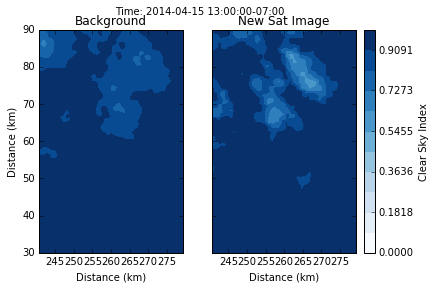

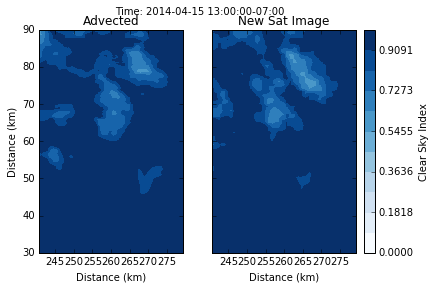

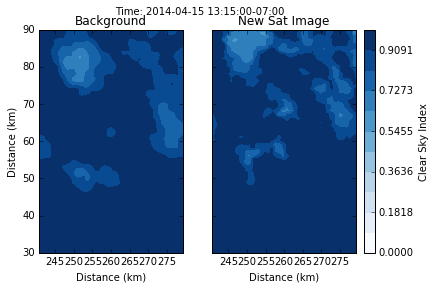

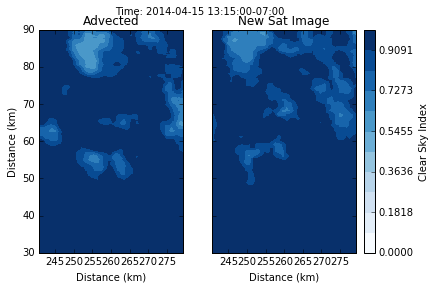

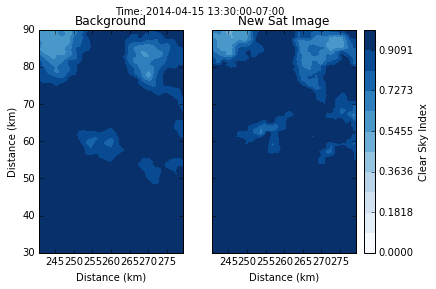

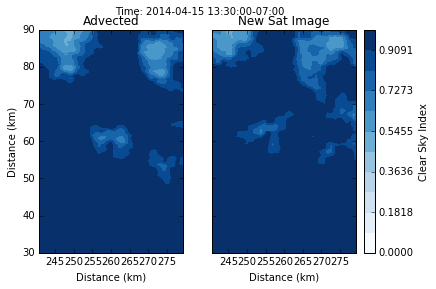

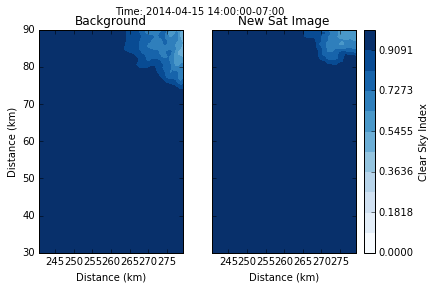

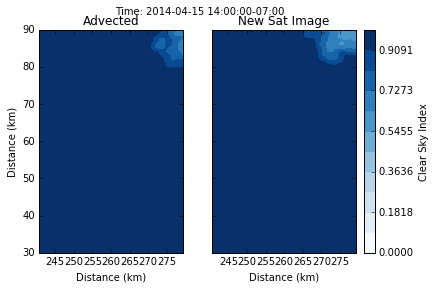

In [86]:
## Only error domain next image
shape = crop_shape

sn_crop = slice(None, None)
we_crop = slice(None, None)
for t in np.arange(background_ni.index.size - 1) + 1:
    this_time = background_ni.index[t]
    
    vmin = 0
    vmax = 1
    nc = 12
    bounds = np.linspace(vmin, vmax, nc)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fraction = 0.10
    suptitle_x = .5*(1 - fraction)
    
    ## background and used sat
    this_x = x_crop[flat_error_domain].reshape(error_domain_shape)
    this_y = y_crop[flat_error_domain].reshape(error_domain_shape)
    nrows, ncols = 1, 2
    dy, dx = this_x.shape
    figsize = plt.figaspect(float(dy * nrows) / ((1 + fraction)*float(dx * ncols)))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
    plt.suptitle('Time: {time}'.format(time=str(this_time)), x=.47)
    im = ax1.pcolormesh(
        this_x,
        this_y,
        background_ni.loc[this_time]
        .values[flat_error_domain + wind_size]
        .reshape(error_domain_shape),
        cmap='Blues', norm=norm)
    ax1.set_title('Background')
    im = ax2.pcolormesh(
        this_x,
        this_y,
        used_sat_ni.loc[this_time]
        .values[flat_error_domain + wind_size]
        .reshape(error_domain_shape),
        cmap='Blues', norm=norm)
    ax2.set_title('New Sat Image')
    cb = plt.colorbar(im, ax=(ax1, ax2), pad=0.02, fraction=fraction)
    cb.set_label('Clear Sky Index')
    ax1.set_aspect('equal', 'datalim')
    ax2.set_aspect('equal', 'datalim')
    ax1.set_xlabel('Distance (km)')
    ax1.set_ylabel('Distance (km)')
    ax2.set_xlabel('Distance (km)')

#     ## Background and advected
#     this_x = x_crop[flat_error_domain].reshape(error_domain_shape)
#     this_y = y_crop[flat_error_domain].reshape(error_domain_shape)
#     nrows, ncols = 1, 2
#     dy, dx = this_x.shape
#     figsize = plt.figaspect(float(dy * nrows) / ((1 + fraction)*float(dx * ncols)))
#     fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
#     plt.suptitle('Time: {time}'.format(time=str(this_time)), x=.47)
#     im = ax1.pcolormesh(
#         this_x,
#         this_y,
#         background_ni.loc[this_time]
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap='Blues', norm=norm)
#     ax1.set_title('Background')
#     im = ax2.pcolormesh(
#         this_x,
#         this_y,
#         advected_ni.loc[this_time]
#         .values[flat_error_domain]
#         .reshape(error_domain_shape),
#         cmap='Blues', norm=norm)
#     ax2.set_title('Advected')
#     cb = plt.colorbar(im, ax=(ax1, ax2), pad=0.02, fraction=fraction)
#     cb.set_label('Clear Sky Index')
#     ax1.set_aspect('equal', 'datalim')
#     ax2.set_aspect('equal', 'datalim')
#     ax1.set_xlabel('Distance (km)')
#     ax1.set_ylabel('Distance (km)')
#     ax2.set_xlabel('Distance (km)')
    
#     ## Background sd and error
#     this_vmax = np.max([background_sd.loc[this_time]
#                        .values[flat_error_domain + wind_size].max(),
#                        abs(background_error.loc[this_time])
#                        .values[flat_error_domain + wind_size].max()])
#     these_bounds = np.linspace(vmin, this_vmax, nc)
#     this_norm = colors.BoundaryNorm(boundaries=these_bounds, ncolors=256)
#     this_x = x_crop[flat_error_domain].reshape(error_domain_shape)
#     this_y = y_crop[flat_error_domain].reshape(error_domain_shape)
#     nrows, ncols = 1, 2
#     dy, dx = this_x.shape
#     figsize = plt.figaspect(float(dy * nrows) / ((1 + fraction)*float(dx * ncols)))
#     fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
#     plt.suptitle('Time: {time}'.format(time=str(this_time)), x=.47)
#     im = ax1.pcolormesh(
#         this_x,
#         this_y,
#         background_sd_ni.loc[this_time]
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap='Greys', norm=this_norm)
#     ax1.set_title('Background sd')
#     im = ax2.pcolormesh(
#         this_x,
#         this_y,
#         abs(background_error_ni.loc[this_time])
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap='Greys', norm=this_norm)
#     ax2.set_title('Background Absolute Error')
#     cb = plt.colorbar(im, ax=(ax1, ax2), pad=0.02, fraction=fraction)
#     cb.set_label('Error (csi)')
#     ax1.set_aspect('equal', 'datalim')
#     ax2.set_aspect('equal', 'datalim')
#     ax1.set_xlabel('Distance (km)')
#     ax1.set_ylabel('Distance (km)')
#     ax2.set_xlabel('Distance (km)')
    

    ## advected and used sat
    this_x = x_crop[flat_error_domain].reshape(error_domain_shape)
    this_y = y_crop[flat_error_domain].reshape(error_domain_shape)
    nrows, ncols = 1, 2
    dy, dx = this_x.shape
    figsize = plt.figaspect(float(dy * nrows) / ((1 + fraction)*float(dx * ncols)))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
    plt.suptitle('Time: {time}'.format(time=str(this_time)), x=.47)
    im = ax1.pcolormesh(
        this_x,
        this_y,
        advected_ni.loc[this_time]
        .values[flat_error_domain + wind_size]
        .reshape(error_domain_shape),
        cmap='Blues', norm=norm)
    ax1.set_title('Advected')
    im = ax2.pcolormesh(
        this_x,
        this_y,
        used_sat_ni.loc[this_time]
        .values[flat_error_domain + wind_size]
        .reshape(error_domain_shape),
        cmap='Blues', norm=norm)
    ax2.set_title('New Sat Image')
    cb = plt.colorbar(im, ax=(ax1, ax2), pad=0.02, fraction=fraction)
    cb.set_label('Clear Sky Index')
    ax1.set_aspect('equal', 'datalim')
    ax2.set_aspect('equal', 'datalim')
    ax1.set_xlabel('Distance (km)')
    ax1.set_ylabel('Distance (km)')
    ax2.set_xlabel('Distance (km)')

In [ ]:
shape = crop_shape
# cmap = 'Set1'
cmap = 'Blues'

sn_crop = slice(None, None)
we_crop = slice(None, None)
for t in np.arange(analysis.index.size - 1) + 1:
    this_time = analysis.index[t]
    
    vmin = 0
    vmax = 1
    nc = 12
    bounds = np.linspace(vmin, vmax, nc)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

#     sn_crop = slice(sn_start, sn_end)
#     sn_start = sn_start + sn_step
#     sn_end = sn_end + sn_step
    
#     we_crop = slice(we_start, we_end)
#     we_start = we_start + we_step
#     we_end = we_end + we_step
    

    plt_x_min = x_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_x_max = x_crop.reshape(shape)[sn_crop, we_crop].max()
    plt_y_min = y_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_y_max = y_crop.reshape(shape)[sn_crop, we_crop].max()
    
#     ## advected
#     plt.figure()
#     im = plt.pcolormesh(
#         x_crop[flat_error_domain].reshape(error_domain_shape),
#         y_crop[flat_error_domain].reshape(error_domain_shape),
#         advected.loc[this_time]
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap=cmap, norm=norm)
#     plt.colorbar(im)
#     plt.title('Advected: ' + str(this_time))
#     plt.axis('equal')
# #     plt.gca().set_xlim((plt_x_min, plt_x_max))
# #     plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    ## background
    plt.figure()
    im = plt.pcolormesh(
        x_crop[flat_error_domain].reshape(error_domain_shape),
        y_crop[flat_error_domain].reshape(error_domain_shape),
        background.loc[this_time]
        .values[flat_error_domain + wind_size]
        .reshape(error_domain_shape),
        cmap=cmap, norm=norm)
    plt.colorbar(im)
    plt.title('Background: ' + str(this_time))
    plt.axis('equal')
#     plt.gca().set_xlim((plt_x_min, plt_x_max))
#     plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    ## analysis
    plt.figure()
    im = plt.pcolormesh(
        x_crop[flat_error_domain].reshape(error_domain_shape),
        y_crop[flat_error_domain].reshape(error_domain_shape),
        abs(analysis.loc[this_time])
        .values[flat_error_domain + wind_size]
        .reshape(error_domain_shape),
        cmap=cmap, norm=norm)
    plt.colorbar(im)
    plt.title('Analysis: ' + str(this_time))
    plt.axis('equal')
#     plt.gca().set_xlim((plt_x_min, plt_x_max))
#     plt.gca().set_ylim((plt_y_min, plt_y_max))

    
    ## background sd
    this_vmax = np.max([background_sd.loc[this_time]
                       .values[flat_error_domain + wind_size].max(),
                       abs(background_error.loc[this_time])
                       .values[flat_error_domain + wind_size].max()])
    these_bounds = np.linspace(vmin, this_vmax, nc)
    this_norm = colors.BoundaryNorm(boundaries=these_bounds, ncolors=256)
    plt.figure()
    im = plt.pcolormesh(
        x_crop[flat_error_domain].reshape(error_domain_shape),
        y_crop[flat_error_domain].reshape(error_domain_shape),
        background_sd.loc[this_time]
        .values[flat_error_domain + wind_size]
        .reshape(error_domain_shape),
        cmap='Greys', norm=this_norm)
    plt.colorbar(im)
    plt.title('Background sd: ' + str(this_time))
    plt.axis('equal')
#     plt.gca().set_xlim((plt_x_min, plt_x_max))
#     plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    ## background error
    plt.figure()
    im = plt.pcolormesh(
        x_crop[flat_error_domain].reshape(error_domain_shape),
        y_crop[flat_error_domain].reshape(error_domain_shape),
        abs(background_error.loc[this_time])
        .values[flat_error_domain + wind_size]
        .reshape(error_domain_shape),
        cmap='Greys', norm=this_norm)
    plt.colorbar(im)
    plt.title('Background absolute error: ' + str(this_time))
    plt.axis('equal')
#     plt.gca().set_xlim((plt_x_min, plt_x_max))
#     plt.gca().set_ylim((plt_y_min, plt_y_max))

#     ## Analysis sd
#     this_vmax = np.max([analysis_sd.loc[this_time]
#                        .values[flat_error_domain + wind_size].max(),
#                        abs(analysis_error.loc[this_time])
#                        .values[flat_error_domain + wind_size].max()])
#     these_bounds = np.linspace(vmin, this_vmax, nc)
#     this_norm = colors.BoundaryNorm(boundaries=these_bounds, ncolors=256)
#     plt.figure()
#     im = plt.pcolormesh(
#         x_crop[flat_error_domain].reshape(error_domain_shape),
#         y_crop[flat_error_domain].reshape(error_domain_shape),
#         abs(analysis_sd.loc[this_time])
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap='Greys', norm=this_norm)
#     plt.colorbar(im)
#     plt.title('Analysis sd: ' + str(this_time))
#     plt.axis('equal')
# #     plt.gca().set_xlim((plt_x_min, plt_x_max))
# #     plt.gca().set_ylim((plt_y_min, plt_y_max))
    
#     ## Analysis error
#     plt.figure()
#     im = plt.pcolormesh(
#         x_crop[flat_error_domain].reshape(error_domain_shape),
#         y_crop[flat_error_domain].reshape(error_domain_shape),
#         abs(analysis_error.loc[this_time])
#         .values[flat_error_domain + wind_size]
#         .reshape(error_domain_shape),
#         cmap='Greys', norm=this_norm)
#     plt.colorbar(im)
#     plt.title('Analysis error: ' + str(this_time))
#     plt.axis('equal')
# #     plt.gca().set_xlim((plt_x_min, plt_x_max))
# #     plt.gca().set_ylim((plt_y_min, plt_y_max))

    print((background.loc[this_time]
          .values[flat_error_domain + wind_size] -
          analysis.loc[this_time]
          .values[flat_error_domain + wind_size]).mean())

In [ ]:
## OI and 15 min assimilation
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 0.7
assimilation_grid_size = 1 # was 5
localization_letkf = 1
sat_inflation = 1
sensor_inflation = 1.5

## old ensemble creation: CI_sigma = .4
# Blow up: 0.01, 0.001; 0.001, 0.001
# Stable: 0.001, 0.01; 0.01, 0.1; 0.1, 0.1
# Noisy: 0.01, 0.01; 0.1, 0.01

## New ensemble creation: CI_sigma = .4
# stable: 0.1, 0.1

## New ensemble creation: CI_sigma = .6
# stable: 0.1, 0.1; 0.2, 0.2
# noisy: 0.1, 0.1 with both inflation of 2

sat_sig = 0.4 #0.01 #0.05 #0.001 <- good
sensor_sig = 0.4 #0.1 #0.05 #.1 #0.01 <- stable
ens_size = 40
wind_sigma = (.4, .4)
wind_size = 2
CI_sigma = .6 # was .1 # was .4

oi_localization = 0.6
oi_sensor_sig = .0088
oi_sat_sig = 5.5*10**-5
oi_inflation = 25000


start_time = '2014-04-15 12:15:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

goes15_azimuth = 220.5
goes15_elevation = 44.1

tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')

cloud_height = 11687

# U_corrected = U_crop.copy()
# V_corrected = V_crop.copy()
U_corrected = U_const.copy() - 3
V_corrected = V_const.copy()

stuff = lf.only_durring_sat(
    sat=csi_crop, x=x_crop, y=y_crop, domain_shape=crop_shape,                                                                                                                                                    
    U=U_corrected, U_shape=U_crop_shape, V=V_corrected, V_shape=V_crop_shape,                                                                                                                                                            
    start_time=start_time, end_time=end_time, dx=dx, dy=dy, C_max=C_max,                                                                                                                                               
    assimilation_grid_size=assimilation_grid_size,                                                                                                                                                            
    localization_letkf=localization_letkf, sat_inflation=sat_inflation,                                                                                                                                                
    sat_sig=sat_sig, ens_size=ens_size,                                                                                                                                                                 
    wind_sigma=wind_sigma, wind_size=wind_size,                                                                                                                                                             
    client=client,
    oi_sensor_sig=oi_sensor_sig,
    oi_sat_sig=oi_sat_sig,
    oi_localization=oi_localization,
    oi_inflation=oi_inflation,
    sensor_data=sensor_CI,
    sensor_loc=sensor_loc,
    sensor_sig=sensor_sig,
    sensor_inflation=sensor_inflation,
    CI_sigma=CI_sigma, location=tus,
    cloud_height=cloud_height, sat_azimuth=goes15_azimuth,
    sat_elevation=goes15_elevation)
# analysis, background, advected, used_sat, OI, sat_time_range, trace_back, trace_analy, background_error, analysis_error_sat, analysis_error_sat_sens, oi_error, sat_error = stuff
analysis, background, advected, used_sat, OI, sat_time_range, error_stats = stuff

In [ ]:
analysis.to_hdf('./results/works_ok/analysis.h5', 'analysis')
background.to_hdf('./results/works_ok/background.h5', 'background')
advected.to_hdf('./results/works_ok/advected.h5', 'advected')
used_sat.to_hdf('./results/works_ok/used_sat.h5', 'used_sat')
OI.to_hdf('./results/works_ok/OI.h5', 'OI')
error_stats.to_hdf('./results/works_ok/error_stats.h5', 'error_stats')

In [ ]:
to_plot = ['sat', 'back', 'analy_sat', 'analy_sat_sens', 'oi']
# to_plot = ['sat', 'oi']
error_stats[to_plot].plot()

In [ ]:
ax = np.sqrt(error_stats[['trace_back', 'trace_analy']]).plot()
# error_stats[to_plot].plot(ax=ax)

In [ ]:
shape = crop_shape

# sn_start = 200
# sn_size = 75 #75
# sn_end = sn_start + sn_size
# we_start = 45
# we_size = sn_size
# we_end = we_start + we_size
# u_approx = U_corrected.ix[0, 0] #22.06
# v_approx = V_corrected.ix[0, 0] #-.84
# scaling = 15*60/250
# we_step = int(round(u_approx*scaling))# - 6
# sn_step = int(round(v_approx*scaling))

sn_crop = slice(None, None)
we_crop = slice(None, None)
for t in np.arange(sat_time_range.size):
    this_time = sat_time_range[t]
    
    vmin=0
    vmax=1

#     sn_crop = slice(sn_start, sn_end)
#     sn_start = sn_start + sn_step
#     sn_end = sn_end + sn_step
    
#     we_crop = slice(we_start, we_end)
#     we_start = we_start + we_step
#     we_end = we_end + we_step
    
#     vmin=None
#     vmax=None
    

    plt_x_min = x_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_x_max = x_crop.reshape(shape)[sn_crop, we_crop].max()
    plt_y_min = y_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_y_max = y_crop.reshape(shape)[sn_crop, we_crop].max()

    plt.figure()
    im = plt.pcolormesh(
        x_crop.reshape(shape)[sn_crop, we_crop],
        y_crop.reshape(shape)[sn_crop, we_crop],
        background.loc[this_time].values[2:].reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Background: ' + str(this_time))
    plt.axis('equal')
    plt.gca().set_xlim((plt_x_min, plt_x_max))
    plt.gca().set_ylim((plt_y_min, plt_y_max))
    
#     plt.figure()
#     im = plt.pcolormesh(
#         x_crop.reshape(shape)[sn_crop, we_crop],
#         y_crop.reshape(shape)[sn_crop, we_crop],
#         advected.loc[this_time].values.reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('Advected: ' + str(this_time))
#     plt.axis('equal')
#     plt.gca().set_xlim((plt_x_min, plt_x_max))
#     plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    
#     plt.figure()
#     im = plt.pcolormesh(
#         x_crop.reshape(shape)[sn_crop, we_crop],
#         y_crop.reshape(shape)[sn_crop, we_crop],
#         used_sat.loc[this_time].values.reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('Sat: ' + str(this_time))
#     plt.axis('equal')
#     plt.gca().set_xlim((plt_x_min, plt_x_max))
#     plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    plt.figure()
    im = plt.pcolormesh(
        x_crop.reshape(shape)[sn_crop, we_crop],
        y_crop.reshape(shape)[sn_crop, we_crop],
        analysis.loc[this_time].values[2:].reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Analysis: ' + str(this_time))
    plt.axis('equal')
    plt.gca().set_xlim((plt_x_min, plt_x_max))
    plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    
#     plt.figure()
#     im = plt.pcolormesh(
#         x_crop.reshape(shape)[sn_crop, we_crop],
#         y_crop.reshape(shape)[sn_crop, we_crop],
#         OI.loc[this_time].values.reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('OI: ' + str(this_time))
#     plt.axis('equal')
#     plt.gca().set_xlim((plt_x_min, plt_x_max))
#     plt.gca().set_ylim((plt_y_min, plt_y_max))

In [ ]:
## array version
shape = crop_shape

# sn_start = 200
# sn_size = 75 #75
# sn_end = sn_start + sn_size
# we_start = 45
# we_size = sn_size
# we_end = we_start + we_size
# u_approx = U_corrected.ix[0, 0] #22.06
# v_approx = V_corrected.ix[0, 0] #-.84
# scaling = 15*60/250
# we_step = int(round(u_approx*scaling))# - 6
# sn_step = int(round(v_approx*scaling))

sn_crop = slice(None, None)
we_crop = slice(None, None)
for t in np.arange(sat_time_range.size):
    this_time = sat_time_range[t]
    
    vmin=0
    vmax=1

#     sn_crop = slice(sn_start, sn_end)
#     sn_start = sn_start + sn_step
#     sn_end = sn_end + sn_step
    
#     we_crop = slice(we_start, we_end)
#     we_start = we_start + we_step
#     we_end = we_end + we_step
    
#     vmin=None
#     vmax=None
    

    plt_x_min = x_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_x_max = x_crop.reshape(shape)[sn_crop, we_crop].max()
    plt_y_min = y_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_y_max = y_crop.reshape(shape)[sn_crop, we_crop].max()

    plt.figure()
    im = plt.pcolormesh(
        x_crop.reshape(shape)[sn_crop, we_crop],
        y_crop.reshape(shape)[sn_crop, we_crop],
        background[t, 2:].reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Background: ' + str(this_time))
    plt.axis('equal')
    plt.gca().set_xlim((plt_x_min, plt_x_max))
    plt.gca().set_ylim((plt_y_min, plt_y_max))
    
#     plt.figure()
#     im = plt.pcolormesh(
#         x_crop.reshape(shape)[sn_crop, we_crop],
#         y_crop.reshape(shape)[sn_crop, we_crop],
#         advected[t].ravel().reshape(shape)[sn_crop, we_crop],
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('Advected: ' + str(this_time))
#     plt.axis('equal')
#     plt.gca().set_xlim((plt_x_min, plt_x_max))
#     plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    plt.figure()
    im = plt.pcolormesh(
        x_crop.reshape(shape)[sn_crop, we_crop],
        y_crop.reshape(shape)[sn_crop, we_crop],
        analysis[t, 2:].reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Analysis: ' + str(this_time))
    plt.axis('equal')
    plt.gca().set_xlim((plt_x_min, plt_x_max))
    plt.gca().set_ylim((plt_y_min, plt_y_max))

In [ ]:
used_sat[0]

In [ ]:
plt.figure()
plt.plot(trace_back[1:])
plt.plot(trace_analy[1:])
plt.legend(['background', 'analysis'])

In [ ]:
shape = crop_shape

sn_start = 200
sn_size = 75 #75
sn_end = sn_start + sn_size
we_start = 45
we_size = sn_size
we_end = we_start + we_size
u_approx = U_corrected.ix[0, 0] #22.06
v_approx = V_corrected.ix[0, 0] #-.84
scaling = 15*60/250
we_step = int(round(u_approx*scaling))# - 6
sn_step = int(round(v_approx*scaling))

sn_crop = slice(None, None)
we_crop = slice(None, None)
for t in np.arange(sat_time_range.size):
    this_time = sat_time_range[t]
    
    vmin=0
    vmax=1.05

    sn_crop = slice(sn_start, sn_end)
    sn_start = sn_start + sn_step
    sn_end = sn_end + sn_step
    
    we_crop = slice(we_start, we_end)
    we_start = we_start + we_step
    we_end = we_end + we_step
    
#     vmin=None
#     vmax=None
    
    plt_x_min = x_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_x_max = x_crop.reshape(shape)[sn_crop, we_crop].max()
    plt_y_min = y_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_y_max = y_crop.reshape(shape)[sn_crop, we_crop].max()
    
    plt.figure()
    im = plt.pcolormesh(
        x_crop.reshape(shape)[sn_crop, we_crop],
        y_crop.reshape(shape)[sn_crop, we_crop],
        background.loc[this_time].values[2:].reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Background: ' + str(this_time))
    plt.axis('equal')
    plt.gca().set_xlim((plt_x_min, plt_x_max))
    plt.gca().set_ylim((plt_y_min, plt_y_max))

    plt.figure()
    im = plt.pcolormesh(
        x_crop.reshape(shape)[sn_crop, we_crop],
        y_crop.reshape(shape)[sn_crop, we_crop],
        advected.loc[this_time].values.reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Advected: ' + str(this_time))
    plt.axis('equal')
    plt.gca().set_xlim((plt_x_min, plt_x_max))
    plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    
    plt.figure()
    im = plt.pcolormesh(
        x_crop.reshape(shape)[sn_crop, we_crop],
        y_crop.reshape(shape)[sn_crop, we_crop],
        used_sat.loc[this_time].values.reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Sat: ' + str(this_time))
    plt.axis('equal')
    plt.gca().set_xlim((plt_x_min, plt_x_max))
    plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    plt.figure()
    im = plt.pcolormesh(
        x_crop.reshape(shape)[sn_crop, we_crop],
        y_crop.reshape(shape)[sn_crop, we_crop],
        analysis.loc[this_time].values[2:].reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Analysis: ' + str(this_time))
    plt.axis('equal')
    plt.gca().set_xlim((plt_x_min, plt_x_max))
    plt.gca().set_ylim((plt_y_min, plt_y_max))
    
    
    plt.figure()
    im = plt.pcolormesh(
        x_crop.reshape(shape)[sn_crop, we_crop],
        y_crop.reshape(shape)[sn_crop, we_crop],
        OI.loc[this_time].values.reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('OI: ' + str(this_time))
    plt.axis('equal')
    plt.gca().set_xlim((plt_x_min, plt_x_max))
    plt.gca().set_ylim((plt_y_min, plt_y_max))

In [ ]:
shape = crop_shape

init_sn_start = 200 + 15
sn_size = 20  #75
init_sn_end = init_sn_start + sn_size

init_we_start = 45 + 15
we_size = sn_size
init_we_end = init_we_start + we_size

u_approx = U_corrected.ix[0, 0] #22.06
v_approx = V_corrected.ix[0, 0] #-.84

scaling = 15*60/250
# we_step = int(round(u_approx*scaling))# - 6
# sn_step = int(round(v_approx*scaling))

# sn_crop = slice(None, None)
# we_crop = slice(None, None)

for t in [0, 1]:#np.arange(sat_time_range.size):
    this_time = sat_time_range[t]
    
    vmin=0
    vmax=1.05
#     vmin=None
#     vmax=None

#     sn_crop = slice(sn_start, sn_end)
#     sn_start = sn_start + sn_step
#     sn_end = sn_end + sn_step
    sn_start = init_sn_start + int(round(v_approx*scaling*t))
    sn_end = init_sn_end + int(round(v_approx*scaling*t))
    sn_crop = slice(sn_start, sn_end)
    
    
#     we_crop = slice(we_start, we_end)
#     we_start = we_start + we_step
#     we_end = we_end + we_step
    we_start = init_we_start + int(round(u_approx*scaling*t))
    we_end = init_we_end + int(round(u_approx*scaling*t))
    we_crop = slice(we_start, we_end)
    
    plt_x_min = x_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_x_max = x_crop.reshape(shape)[sn_crop, we_crop].max()
    plt_y_min = y_crop.reshape(shape)[sn_crop, we_crop].min()
    plt_y_max = y_crop.reshape(shape)[sn_crop, we_crop].max()
    
    tempx = np.arange(
        plt_x_min - .25/2, plt_x_max + .25/2 + .25, .25)
    tempy = np.arange(
        plt_y_min - .25/2, plt_y_max + .25/2 + .25, .25)
    this_x, this_y = np.meshgrid(tempx, tempy)
    

    fig1, (ax1)= plt.subplots(1, figsize=(10, 10))
    ax1.pcolormesh(
        this_x, this_y,
        advected.loc[this_time].values.reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax, shading='flat')
    for (i, j), label in np.ndenumerate(
            advected.loc[this_time].values.reshape(shape)[sn_crop, we_crop]):
        label = np.round(label, decimals=2)
        x = this_x[i, j]
        y = this_y[i, j]
        ax1.text(x + .25/2, y + .25/2, label, ha='center', va='center')
    ax1.axis('equal') 
    plt.title('Advected: ' + str(this_time))
    plt.gca().set_xlim((plt_x_min - .25/2, plt_x_max + .25/2))
    plt.gca().set_ylim((plt_y_min - .25/2, plt_y_max + .25/2))
    plt.show()

    
    fig1, (ax1)= plt.subplots(1, figsize=(10, 10))
    ax1.pcolormesh(
        this_x, this_y,
        used_sat.loc[this_time].values.reshape(shape)[sn_crop, we_crop],
        cmap='Blues', vmin=vmin, vmax=vmax, shading='flat')
    for (i, j), label in np.ndenumerate(
            used_sat.loc[this_time].values.reshape(shape)[sn_crop, we_crop]):
        label = np.round(label, decimals=2)
        x = this_x[i, j]
        y = this_y[i, j]
        ax1.text(x + .25/2, y + .25/2, label, ha='center', va='center')
    ax1.axis('equal') 
    plt.title('Sat: ' + str(this_time))
    plt.gca().set_xlim((plt_x_min - .25/2, plt_x_max + .25/2))
    plt.gca().set_ylim((plt_y_min - .25/2, plt_y_max + .25/2))
    plt.show()  

In [ ]:
## only OI

# Use actual satellite image as Truth to find error statistics
# forecast and analysis trace p
# Also do the same by converting cloudiness to csi and compare to sensor
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 0.7
assimilation_grid_size = 1 # was 5
localization_letkf = 2
sat_inflation = 1
sensor_inflation = 1

sat_sig = 0.001 #0.01 #0.05 #0.001 <- good
sensor_sig = 0.01 #0.1 #0.05 #.1
ens_size = 40
wind_sigma = (.5, .5)
wind_size = 2
CI_sigma = .4 # was .1

oi_localization = 0.6
oi_sensor_sig = .0088
oi_sat_sig = 5.5*10**-5
oi_inflation = 2500


start_time = '2014-04-15 12:30:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

goes15_azimuth = 220.5
goes15_elevation = 44.1

tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')

cloud_height = 8222

stuff = lf.only_oi(
    sat=csi_crop, x=x_crop, y=y_crop, domain_shape=crop_shape,                                                                                                                                                                                                                                                                                                             
    start_time=start_time, end_time=end_time,
    oi_sensor_sig = oi_sensor_sig,
    oi_sat_sig = oi_sat_sig,
    oi_localization=oi_localization,
    oi_inflation=oi_inflation,
    sensor_data=sensor_CI,
    sensor_loc=sensor_loc,
    location=tus,
    cloud_height=cloud_height, sat_azimuth=goes15_azimuth,
    sat_elevation=goes15_elevation)
analysis, background, advected, used_sat, OI, sat_time_range, trace_back, trace_analy = stuff

In [ ]:
analysis_only_sat = analysis.copy()
background_only_sat = background.copy()
advected_only_sat = advected.copy()
sat_time_range_only_sat = sat_time_range.copy()

In [ ]:
plt.figure()
plt.plot(trace_back[1:])
plt.plot(trace_analy[1:])
plt.legend(['background', 'analysis'])

In [ ]:
#0.001
shape = crop_shape
for t in range(sat_time_range.size):
    this_time = sat_time_range[t]
    
    vmin=0
    vmax=1.2
    
    plt.figure()
    im = plt.pcolormesh(x_crop.reshape(shape), y_crop.reshape(shape),
        background[t, 2:].reshape(shape) ,
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Background: ' + str(this_time))
    plt.axis('equal')
    
#     plt.figure()
#     im = plt.pcolormesh(x_crop.reshape(shape), y_crop.reshape(shape),
#         advected[t].reshape(shape),
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('advected: ' + str(this_time))
#     plt.axis('equal')
    
    plt.figure()
    im = plt.pcolormesh(x_crop.reshape(shape), y_crop.reshape(shape),
        (analysis[t, 2:]).reshape(shape),
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Analysis: ' + str(this_time))
    plt.axis('equal')

In [ ]:
# update SUNY coefficients

importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 0.7
assimilation_grid_size = 5 #was 5
localization = 2
sat_inflation = 1
sensor_inflation = 1.2

goes15_azimuth = 220.5
goes15_elevation = 44.1

sat_sig = 0.01 #0.01 #0.05
sensor_sig = 0.05 #0.1 #0.05
ens_size = 40
wind_sigma = (.5, .5)
wind_size = 2
CI_sigma = .0001
coeff_sigma = np.array([.3, .5])
SUNY_coeff = np.array(np.array([2.36, -6.2, 6.22, -2.63, -0.58, 1]))

tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')

cloud_height = 8222

start_time = '2014-04-15 12:45:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:45:00' #Gets boring shortly after 14:00:00

analysis, analysis_error, background, background_error, advected, time_range, trace_back, trace_analy = lf.main(
    sat=cci_crop, x=x_crop, y=y_crop, domain_shape=crop_shape,                                                                                                                                                    
    U=U_crop, U_shape=U_crop_shape, V=V_crop, V_shape=V_crop_shape,                                                                                                                                                            
    start_time=start_time, end_time=end_time, dx=dx, dy=dy, C_max=C_max,                                                                                                                                               
    assimilation_grid_size=assimilation_grid_size,                                                                                                                                                            
    localization_letkf=localization_letkf, sat_inflation=sat_inflation,                                                                                                                                                
    sat_sig=sat_sig, ens_size=ens_size,                                                                                                                                                                 
    wind_sigma=wind_sigma, wind_size=wind_size,                                                                                                                                                             
    client=client,
    sensor_data=sensor_CI,
    sensor_loc=sensor_loc,
    sensor_sig=sensor_sig,
    sensor_inflation=sensor_inflation,
    CI_sigma=CI_sigma, coeff_sigma=coeff_sigma, location=tus,
    cloud_height=cloud_height, sat_azimuth=goes15_azimuth,
    sat_elevation=goes15_elevation)

In [ ]:
shape = crop_shape
for t in range(time_range.size):
    this_time = time_range[t]
    
    vmin=0
    vmax=1.05
    
#     vmin=None
#     vmax=None

    this_coeff_pert = np.array(
        [0,0,0,0, background[t, 1] - background[t, 0], background[t, 0]])
    this_background = np.polyval(SUNY_coeff + this_coeff_pert, background[t, 2 + 2:].reshape(shape))
    plt.figure()
    im = plt.pcolormesh(x_crop.reshape(shape), y_crop.reshape(shape),
        this_background,
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Background: ' + str(this_time))
    plt.axis('equal')
    
#     plt.figure()
#     im = plt.pcolormesh(x_crop.reshape(shape), y_crop.reshape(shape),
#         advected[t].reshape(shape),
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('advected: ' + str(this_time))
#     plt.axis('equal')
    
    this_coeff_pert = np.array(
        [0,0,0,0, analysis[t, 1] - analysis[t, 0], analysis[t, 0]])
    this_analysis = np.polyval(SUNY_coeff + this_coeff_pert, analysis[t, 2 + 2:].reshape(shape))
    plt.figure()
    im = plt.pcolormesh(x_crop.reshape(shape), y_crop.reshape(shape),
        this_analysis,
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Analysis: ' + str(this_time))
    plt.axis('equal')
    
#     plt.figure()
#     im = plt.pcolormesh(x_crop.reshape(shape), y_crop.reshape(shape),
#         this_analysis-this_background,
#         cmap='Blues', vmin=vmin, vmax=vmax)
#     plt.colorbar(im)
#     plt.title('Analysis: ' + str(this_time))
#     plt.axis('equal')

In [ ]:
plt.figure()
plt.plot(np.sqrt(trace_back[1:]))
plt.plot(np.sqrt(trace_analy[1:]))
plt.legend(['background', 'analysis'])

In [ ]:
analysis_rmse = np.sqrt((analysis_error**2).mean(axis=1))
background_rmse = np.sqrt((background_error**2).mean(axis=1))
plt.figure()
plt.plot(background_rmse[1:])
plt.plot(analysis_rmse[1:])
plt.legend(['background', 'analysis'])

In [ ]:
plt.figure()
plt.plot(analysis_error)

In [ ]:
plt.figure()
plt.plot(np.sqrt((background_error**2).mean(axis=1))[1:])
plt.plot(np.sqrt((analysis_error**2).mean(axis=1))[1:])
plt.legend(['background', 'analysis'])

In [ ]:
from functools import partial

In [ ]:
start_time = '2014-04-15 12:30:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

assimilation_grid_size = 5


short_fun_d = partial(lf.main,
    sat=sat_15.isel(west_east=x_crop, south_north=y_crop),
    wind=wind_15_smooth.isel(west_east=x_crop, west_east_stag=x_crop_stag,
                             south_north=y_crop, south_north_stag=y_crop_stag),
    sensor_data=sensor_CI,
    sensor_loc=sensor_loc,
    start_time=start_time, end_time=end_time, dx=dx, dy=dy,
    C_max=C_max,
    assimilation_grid_size=assimilation_grid_size,
    localization_length=localization, inflation=inflation,
    sat_sig=sat_sig, sensor_sig=sensor_sig, ens_size=ens_size,
    wind_sigma=wind_sigma, wind_size=wind_size, CI_sigma=CI_sigma,
    location=tus, cloud_height=cloud_height, sat_azimuth=goes15_azimuth,
    sat_elevation=goes15_elevation, client=client)

In [ ]:
%lprun -f lf.main short_fun_d()

In [ ]:
np.arange(16).reshape(4,4).mean()

In [ ]:
# Minimize error from wind error # not the best
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 0.7

start_time = '2014-04-15 12:30:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

u_pert = 1
v_pert = 0

x_crop_stag = slice(x_crop.start - 1, x_crop.stop)
y_crop_stag = slice(y_crop.start - 1, y_crop.stop)

for u_pert in np.linspace(-5, 5, 10):
    for v_pert in np.linspace(-2, 2, 5):
        print('u_pert: ' + str(u_pert))
        print('v_pert: ' + str(v_pert))
        lf.just_advection(
            sat=sat_15.isel(west_east=x_crop, south_north=y_crop),
            wind=wind_15_smooth.isel(west_east=x_crop, west_east_stag=x_crop_stag,
                                     south_north=y_crop, south_north_stag=y_crop_stag),
            u_pert=u_pert, v_pert=v_pert,
            start_time=start_time, end_time=end_time, dx=dx, dy=dy,
            C_max=C_max)